In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt 
import seaborn as sns

import PIL
from PIL import Image, ImageDraw
import tensorflow as tf
from tensorflow import keras
# import tensorflow_datasets as tfds
%matplotlib inline

# Load data 

### Preparing structured data

In [2]:
data_table = pd.read_csv("data/structured data/headcount-table.csv")
print(data_table.info())
data_table.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5733 entries, 0 to 5732
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Name       5733 non-null   object
 1   HeadCount  5733 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.7+ KB
None


,Name,HeadCount
0,10001.jpg,4
1,10002.jpg,4
2,10003.jpg,2
3,10004.jpg,3
4,10006.jpg,4


In [3]:
bbox_table = pd.read_csv("data/structured data/bbox_table.csv")
print(bbox_table.info())
print('--------------------------------------')
print("Unique photos: ",len(bbox_table['Name'].unique()))
print('--------------------------------------')
bbox_table.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24533 entries, 0 to 24532
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    24533 non-null  object
 1   width   24533 non-null  int64 
 2   height  24533 non-null  int64 
 3   xmin    24533 non-null  int64 
 4   ymin    24533 non-null  int64 
 5   xmax    24533 non-null  int64 
 6   ymax    24533 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 1.3+ MB
None
--------------------------------------
Unique photos:  5733
--------------------------------------


,Name,width,height,xmin,ymin,xmax,ymax
0,10001.jpg,612,408,192,199,230,235
1,10001.jpg,612,408,247,168,291,211
2,10001.jpg,612,408,321,176,366,222
3,10001.jpg,612,408,355,183,387,214
4,10002.jpg,612,408,339,165,378,202


### Preparing image data 

In [4]:
classes = data_table.HeadCount.unique()
classes

array([ 4,  2,  3,  6,  7,  8,  5, 11,  1,  9, 10, 21, 13, 14, 15, 17, 12,
       20, 16, 18, 31, 23, 24, 77, 28, 22, 19, 25, 29], dtype=int64)

#### Encode dataset as tf.dataset obeject

In [23]:
# Train split
# head_count_labels = list(data_table.HeadCount)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='data/image_data/train',
    labels='inferred',
    label_mode=None,
    color_mode="grayscale",
    validation_split=0.25,
    subset='training',
    batch_size=5733,
    image_size=(408, 612),
    seed=42)

Found 5733 files belonging to 29 classes.
Using 4300 files for training.


In [6]:
# test split
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='data/image_data/train',
    labels='inferred',
    label_mode='int',
    color_mode="grayscale",
    validation_split=0.25,
    subset='validation',
    batch_size=5733,
    image_size=(408, 612),
    seed=42)

Found 5733 files belonging to 29 classes.
Using 1433 files for validation.


In [7]:
sample = train_ds.take(1)
sample

<TakeDataset shapes: ((None, 408, 612, 1), (None,)), types: (tf.float32, tf.int32)>

#### convert dataset objects to numpy arrays

In [8]:
import tensorflow_datasets as tfds

In [28]:
# train dataset to numpy array
for image,label in tfds.as_numpy(train_ds):
    X_train = image
    y_train = label

    print('train dataset shape: ',X_train.shape)
    print('--------')
    print('data labels shape: ', y_train.shape)

train dataset shape:  (4300, 408, 612, 1)
--------
data labels shape:  (4300,)


train dataset has 4300 images consisting of three color channels each represented as an array 408 pixels high by 612 pixels long 

In [29]:

for image,label in tfds.as_numpy(test_ds):
    X_test = image
    y_test = label

    print('test dataset shape: ', X_test.shape)
    print('--------')
    print('data labels shape: ', y_test.shape)

test dataset shape:  (1433, 408, 612, 1)
--------
data labels shape:  (1433,)


test dataset has 1433 images consisting of three color channels each represented as an array 408 pixels high by 612 pixels long

### Convert 2d arrays to 1d vectors

In [30]:
X_train_reshape = X_train.reshape(4300,408*612).astype('float32')
X_test_reshape = X_test.reshape(1433,408*612).astype('float32')


print('train vectorized: ', X_train_reshape.shape)
print('--------')
print('test vectorized: ', X_test_reshape.shape)


train vectorized:  (4300, 408, 612, 1)
--------
test vectorized:  (1433, 408, 612, 1)


### Normalize image data

In [12]:
# X_train /= 255.
# X_test /= 255.

## Preprocess Labels

In [13]:
from keras.utils import to_categorical

In [14]:
# maps the keras dataset object labels to the corresponding class labels (i.e. the headcount)
label_path = os.listdir('data/image_data/train/')
unique_labels = list(np.unique(y_train)) + list(np.unique(y_test)) 
# print(unique_labels)
class_label_map = {i:int(label_path[i]) for i in unique_labels}
print(class_label_map)

{0: 1, 1: 10, 2: 11, 3: 12, 4: 13, 5: 14, 6: 15, 7: 16, 8: 17, 9: 18, 10: 19, 11: 2, 12: 20, 14: 22, 15: 23, 16: 24, 17: 25, 19: 29, 20: 3, 21: 31, 22: 4, 23: 5, 24: 6, 25: 7, 26: 77, 27: 8, 28: 9, 13: 21, 18: 28}


In [15]:
y_train_ohe = to_categorical(y_train,len(class_label_map.keys()))
y_test_ohe = to_categorical(y_test,len(class_label_map.keys()))

y_test_ohe[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]],
      dtype=float32)

### Sanity check (display image data with correct labels)

tf.Tensor([20 20 22 ... 11 11 22], shape=(4300,), dtype=int32)
tf.Tensor(20, shape=(), dtype=int32)


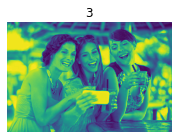

In [16]:
plt.figure(figsize=(10, 10))
path = os.listdir('data/image_data/train/')

for images, labels in train_ds.take(1):
  i = 0
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.title(path[labels[i]])
  plt.axis("off")
print(labels)
print(labels[0])


In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(path[labels[i]])
    plt.axis("off")

### build a baseline model

In [10]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten

In [20]:
base_model = Sequential()

base_model.add(Dense(50, activation='relu',input_shape=(408*612,)))

base_model.add(Dense(25, activation='softmax'))

In [21]:
base_model.compile(loss='sparse_categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

In [14]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [13]:
print(X_train.shape)
print(y_train_ohe.shape)

NameError: name 'X_train' is not defined

In [24]:
base_model.fit(train_ds,
               batch_size=5733,
               epochs=5,
               validation_data=test_ds,
               )


Epoch 1/5


ValueError: in user code:

    c:\Users\zethu\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    c:\Users\zethu\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\Users\zethu\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\Users\zethu\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\Users\zethu\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\Users\zethu\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    c:\Users\zethu\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    c:\Users\zethu\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    c:\Users\zethu\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected axis -1 of input shape to have value 249696 but received input with shape [None, 408, 612, 1]


In [17]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                12484850  
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
Total params: 12,486,125
Trainable params: 12,486,125
Non-trainable params: 0
_________________________________________________________________


# Try again

In [25]:
import os
from keras.preprocessing.image import ImageDataGenerator


In [28]:

# Load the images; be sure to also preprocess these into tensors 
train_dir = 'data/image_data/train/'
# val_dir = 'cats_dogs_downsampled/val/'
# test_dir = 'cats_dogs_downsampled/test/' 


In [29]:

train_datagen = ImageDataGenerator(rescale=1./255)
# val_datagen = ImageDataGenerator(rescale=1./255)

train_data_generator = train_datagen.flow_from_directory(
                       train_dir,
                       target_size=(408,612),
                       batch_size=20,
                       class_mode='binary')

# validation_generator = val_datagen.flow_from_directory(
#                        val_dir,
#                        target_size=(150,150),
#                        batch_size=20,
#                        class_mode='binary')

Found 5733 images belonging to 29 classes.


In [30]:
base_model = Sequential()

base_model.add(Dense(50, activation='relu',input_shape=(408*612,)))

base_model.add(Dense(25, activation='softmax'))

In [31]:
base_model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

In [45]:
train_table = data_table.sample(frac=0.75,random_state=42) 
test_table = data_table.sample(frac=.25,random_state=42)